<a href="https://colab.research.google.com/github/saathwikad/Visual_Question_Answering/blob/main/VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
# Create .kaggle directory if it doesn't exist
!mkdir ~/.kaggle

# Move the uploaded kaggle.json to ~/.kaggle/
!mv kaggle.json ~/.kaggle/

In [3]:
# Download the dataset
!kaggle datasets download -d bhavikardeshna/visual-question-answering-computer-vision-nlp

 93% 381M/411M [00:04<00:00, 38.3MB/s]
100% 411M/411M [00:04<00:00, 97.8MB/s]


In [4]:
import zipfile
import os

# Path to the downloaded zip file
zip_file_path = 'visual-question-answering-computer-vision-nlp.zip'  # Update with your file name

# Directory to extract the contents to
extracted_dir_path = 'vqa_cv'  # Update with your desired directory name

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extracted_dir_path)

# List the contents of the extracted directory
extracted_files = os.listdir(extracted_dir_path)
print("Files extracted successfully:", extracted_files)

Files extracted successfully: ['dataset']


In [5]:
data_train = pd.read_csv("/content/vqa_cv/dataset/data_train.csv")

In [6]:
train_images = pd.read_fwf("/content/vqa_cv/dataset/train_images_list.txt")

In [7]:
data_train

,question,answer,image_id
0,what is the object on the shelves,cup,image100
1,how man chairs are there,6,image888
2,what is hanged to the right side of the bed,curtain,image1174
3,how many picture are on the wall,2,image942
4,what is the object on the floor behind the rack,room_divider,image1220
...,...,...,...
9969,what is to the right of the table,cabinet,image1349
9970,what is the colour of the lamp,black,image956
9971,what is behind the lamp,curtain,image1009
9972,what is the object close to the middle counter...,stove,image908


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9974 entries, 0 to 9973
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  9974 non-null   object
 1   answer    9974 non-null   object
 2   image_id  9974 non-null   object
dtypes: object(3)
memory usage: 233.9+ KB


In [9]:
data_train.describe()

,question,answer,image_id
count,9974,9974,9974
unique,4961,1260,1442
top,what is on the table,2,image8
freq,200,442,25


In [10]:
train_images

,image3
0,image4
1,image5
2,image6
3,image7
4,image8
...,...
789,image143
790,image143
791,image143
792,image143


In [11]:
train_images.describe()

,image3
count,794
unique,591
top,image106
freq,11


In [13]:
qa = pd.read_fwf("/content/vqa_cv/dataset/all_qa_pairs.txt")

In [19]:
from PIL import Image
import torch
import torch.nn as nn

In [20]:
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)


In [37]:
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score
!pip install datasets
from datasets import load_dataset, set_caching_enabled

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00


In [23]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

In [27]:
answers = pd.read_fwf("/content/vqa_cv/dataset/answer_space.txt")

In [28]:
answers

,1
0,10
1,11
2,12
3,13
4,14
...,...
576,wooden_plank
577,wooden_planks
578,xbox
579,yellow


In [29]:
answers.describe()

,1
count,581
unique,581
top,10
freq,1


In [41]:
dataset = load_dataset(
    "csv",
    data_files={
        "train": os.path.join("..", "/content/vqa_cv/dataset", "data_train.csv"),
        "test": os.path.join("..", "/content/vqa_cv/dataset", "data_eval.csv")
    }
)

with open(os.path.join("..", "/content/vqa_cv/dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

Map:   0%|          | 0/9974 [00:00<?, ? examples/s]

Map:   0%|          | 0/2494 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

In [45]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join("..", "/content/vqa_cv/dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

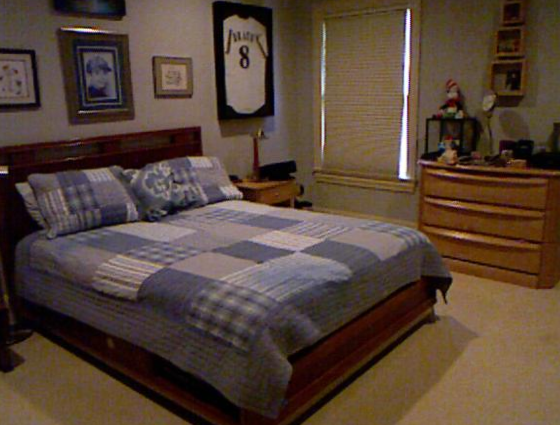

Question:	 how many pictures are there on the wall
Answer:		 5 (Label: 15)


In [47]:
showExample()